# sscan as 1D Flyer

In this notebook, the EPICS *sscan* record is demonstrated as a bluesky *Flyer*.

<font color="red">NOTE</font>: This notebook is under construction!

## Overview

The [bluesky](https://blueskyproject.io/bluesky) package has support for data acquisition using an external data collector.  The design prototype collector is a _fly_ scan controller, operating outside the _bluesky_ process, which performs its readings of detector(s) during continuous (_on-the-fly_) motion of one or more positioners.  Triggering of the detectors must also be part of the external controller.  The description is that this type of [asynchronous acquisition](http://nsls-ii.github.io/bluesky/async.html#asynchronous-acquisition) requires fine-grained timing beyond the capabilities of *bluesky*.

> Flying means: “Let the hardware take control, cache data externally, and then transfer all the data to the RunEngine at the end.” This is essential when the data acquisition rates are faster than the RunEngine or Python can go.

_Any_ external data acquisition controller or data logger is suitable for use as a bluesky *Flyer*.  It is not necessary for the external controller to conduct its acquisition at high rates.

The EPICS [sscan record](https://epics.anl.gov/bcda/synApps/sscan/sscanRecord.html) is an example of an external data acquisition controller.  It supports various scan types (step, list, continuous) with flexible configuration for up to four positioners and dozens of detectors, as well as scans of up to four dimensions.  The *sscan* record is used by many APS beam lines for routine data collection.

### Documentation links

The documentation for *Flyer*s is distributed across the *bluesky* and *ophyd* packages:

- http://nsls-ii.github.io/bluesky/plans.html#summary
- http://nsls-ii.github.io/bluesky/generated/bluesky.plans.fly.html#bluesky.plans.fly
- http://nsls-ii.github.io/bluesky/plans.html#asynchronous-plans-fly-scans-and-monitoring
- http://nsls-ii.github.io/bluesky/async.html
- http://nsls-ii.github.io/ophyd/generated/ophyd.flyers.html
- http://nsls-ii.github.io/ophyd/architecture.html#fly-able-interface

## 1D step scans using sscan record

Use the [sscan record](https://epics.anl.gov/bcda/synApps/sscan/sscanRecord.html) as an [ophyd Flyer](http://nsls-ii.github.io/bluesky/async.html) for data acquisition with the [bluesky](http://nsls-ii.github.io/bluesky) [fly](http://nsls-ii.github.io/bluesky/generated/bluesky.plans.fly.html#bluesky.plans.fly) plan.  Consider the case of [1D step scans using sscan record](https://epics.anl.gov/bcda/synApps/sscan/sscanRecord.html#HEADING_1-1).

Suggest the _noisy *v* m1_ scan, done as 1-D step scan with `sscan` record.  `noisy` is the *swait* record calculating a Lorentzian peak based on `m1` position.

We'll build a custom Python class, from `apstools.synApps.SscanRecord` (a subclass of `ophyd.Device`), that support the EPICS *sscan* record and add the `ophyd.FlyerInterface` to that class.  A class method will configure the Device staging to setup the sscan record for a 1-D step scan using the `m1` positioner and the `noisy` detector.  `noisy` is implemented as an EPICS [*swait*](https://htmlpreview.github.io/?https://raw.githubusercontent.com/epics-modules/calc/R3-6-1/documentation/swaitRecord.html) record configured to recalculate a Lorentzian profile when the `m1` readback value changes.  The center, width, and height are set randomly as this bluesky instrument package is started.  The center of the simulated peak will be defined somewhere between +/- 1.

### Load the `instrument` package

In [1]:
%matplotlib widget

import os, pathlib, sys
sys.path.append(os.path.abspath(os.path.join(pathlib.Path.home(), "bluesky")))
from instrument.collection import *

I Sun-18:10:32 - ############################################################ startup
I Sun-18:10:32 - logging started
I Sun-18:10:32 - logging level = 10
I Sun-18:10:32 - /home/prjemian/bluesky/instrument/collection.py
I Sun-18:10:32 - /home/prjemian/bluesky/instrument/mpl/notebook.py
I Sun-18:10:32 - #### Bluesky Framework ####
I Sun-18:10:32 - /home/prjemian/bluesky/instrument/framework/check_python.py
I Sun-18:10:32 - /home/prjemian/bluesky/instrument/framework/check_bluesky.py


Activating auto-logging. Current session state plus future input saved.
Filename       : /home/prjemian/Documents/projects/BCDA-APS/bluesky_training/.logs/ipython_console.log
Mode           : rotate
Output logging : True
Raw input log  : False
Timestamping   : True
State          : active


I Sun-18:10:33 - /home/prjemian/bluesky/instrument/framework/initialize.py
I Sun-18:10:34 - using databroker catalog 'training'
I Sun-18:10:34 - /home/prjemian/bluesky/instrument/framework/metadata.py
I Sun-18:10:34 - #### Devices ####
I Sun-18:10:34 - /home/prjemian/bluesky/instrument/devices/area_detector.py
I Sun-18:10:34 - /home/prjemian/bluesky/instrument/devices/calculation_records.py
I Sun-18:10:36 - /home/prjemian/bluesky/instrument/devices/ioc_stats.py
I Sun-18:10:36 - /home/prjemian/bluesky/instrument/devices/motors.py
I Sun-18:10:36 - /home/prjemian/bluesky/instrument/devices/noisy_detector.py
I Sun-18:10:36 - /home/prjemian/bluesky/instrument/devices/scaler.py
I Sun-18:10:37 - /home/prjemian/bluesky/instrument/devices/shutter_simulator.py
I Sun-18:10:37 - /home/prjemian/bluesky/instrument/devices/temperature_signal.py
I Sun-18:10:37 - #### Callbacks ####
I Sun-18:10:37 - /home/prjemian/bluesky/instrument/callbacks/spec_data_file_writer.py
I Sun-18:10:37 - writing to SPEC fi

Add this notebook's name to the RunEngine metadata and define the IOC's prefix.

In [2]:
RE.md["notebook"] = "sscan_1d_flyer"
ioc = "gp:"

## Bluesky step scan

We are told that the `noisy` signal will show a peak when `m1` is moved over the range `[-1 .. +1]`.  Use *bluesky* to show that peak.

In [3]:
if False:
    # show a pre-assembled bluesky.plans.scan() acquisition
    RE(bp.scan([noisy], m1, -1.1, 1.1, 21, md=dict(purpose="demo bluesky scan plan")))

## sscan as Bluesky Flyer

Load some structures to be used.

The *sscan* record will record the time stamp for each point (relative to the scan's starting time) if the text `time` or `TIME` is used as the readback of one of the positioners.  This reduces the number of possible positioners to three.

To get the positioner setpoint value for each point, add the motor's readback PV as an additional detector.

In [4]:
from ophyd import DeviceStatus, Signal
from ophyd.flyers import FlyerInterface
from apstools.synApps import SscanRecord

<details>
<summary>if save data is to be used</summary>

```python
# TODO: if save data is to be used

# # configure saveData for data collection into MDA files:
# save_data.stage_sigs["file_system"] = "/tmp"
# save_data.stage_sigs["subdirectory"] = "saveData"
# save_data.stage_sigs["base_name"] = "sscan1_"
# save_data.stage_sigs["next_scan_number"] = 1
# save_data.stage_sigs["comment1"] = "testing"
# save_data.stage_sigs["comment2"] = "configured and run from ophyd"
```

</details>

----------------

In [5]:
class SscanFlyer_1D_StepSimple(FlyerInterface, SscanRecord):

    def __init__(self, *args, **kwargs):
        self._acquiring = False

        super().__init__(*args, **kwargs)

    def stage(self):
        super().stage()
        self.select_channels()

    def unstage(self):
        super().unstage()
        self.select_channels()

    def setup_staging_1D_step(self, start=-1.1, finish=1.1, num=21, ddelay=0.01, pdelay=0):
        """Configure sscan record for 1D step scan: noisy v. m1"""
        self.xref = dict(
            raw_positioners=[m1, ],
            positioners=[m1, ],
            raw_detectors=[noisy, ],
            detectors=[noisy, m1.user_setpoint]  # include motor setpoints array
        )
        self.stage_sigs["number_points"] = num
        self.stage_sigs["pasm"] = "PRIOR POS"
        self.stage_sigs["positioner_delay"] = pdelay
        for i, p in enumerate(self.xref["raw_positioners"]):
            self.stage_sigs[f"positioners.p{i+1}.setpoint_pv"] = p.user_setpoint.pvname
            self.stage_sigs[f"positioners.p{i+1}.readback_pv"] = p.user_readback.pvname
            self.stage_sigs[f"positioners.p{i+1}.start"] = start
            self.stage_sigs[f"positioners.p{i+1}.end"] = finish
        self.stage_sigs["detector_delay"] = ddelay
        for i, d in enumerate(self.xref["detectors"]):
            self.stage_sigs[f"detectors.d{i+1:02d}.input_pv"] = d.pvname

        # get timestamp of each point in the scan
        # This is a sscan record trick that returns the time (s) since the scan started.
        self.stage_sigs[f"positioners.p4.readback_pv"] = "time"

    def read_configuration(self):
        return {}

    def describe_configuration(self):
        return {}

    def kickoff(self):
        """Start the sscan record."""
        # self.setup_staging_1D_step()
        self.stage()
        time.sleep(0.1)

        # set(), do not `yield`, in kickoff()
        self.execute_scan.set(1)  # start the sscan record
        self._acquiring = True

        status = DeviceStatus(self)
        status.set_finished()  # means that kickoff was successful
        return status

    def complete(self):
        """Wait for sscan to complete."""
        logging.info("complete() starting")
        if not self._acquiring:
            raise RuntimeError("Not acquiring")

        st = DeviceStatus(self)
        cb_started = False

        def execute_scan_cb(value, timestamp, **kwargs):
            """Watch ``sscan.EXSC`` for completion."""
            value = int(value)
            if cb_started and value == 0:
                logging.info("complete() ending")
                self.unstage()
                self._acquiring = False
                self.execute_scan.unsubscribe(execute_scan_cb)
                if not st.done:
                    logging.info("Setting %s execute status to `done`.", self.name)
                    st.set_finished()

        self.execute_scan.subscribe(execute_scan_cb)
        # self.execute_scan.set(1)
        cb_started = True
        return st

    def describe_collect(self):
        """
        Provide schema & meta-data from collect().
        
        http://nsls-ii.github.io/ophyd/generated/ophyd.flyers.FlyerInterface.describe_collect.html
        """
        dd = {}
        dd.update(m1.describe())
        dd.update(noisy.describe())
        return {self.name: dd}

    def collect(self):
        """
        Retrieve all collected data (after complete()).
        
        Retrieve data from the flyer as proto-events.
        http://nsls-ii.github.io/ophyd/generated/ophyd.flyers.FlyerInterface.collect.html
        """
        if self._acquiring:
            raise RuntimeError("Acquisition still in progress. Call complete() first.")
        
        def get_data_from_sscan(obj, n):
            """Read a sscan array and return as Python list."""
            data = obj.read()[obj.name]
            data["value"] = list(data["value"][:n])
            return data

        def mkdoc(seq_num, values):
            """Bundle the dictionary of values into a raw event document."""
            timestamp = values.pop("__ts__")
            yield dict(
                seq_num=seq_num,
                time=timestamp,
                data={k: v for k, v in values.items()},
                timestamps={k: timestamp for k in values},
            )

        def read_sscan_data(scan):
            """Get the sscan arrays and yield as discrete events."""
            _cp = scan.current_point.read()[scan.current_point.name]
            n = _cp["value"]
            ts_last_point = _cp["timestamp"]

            # get the per-step time stamps from positioner 4
            ts_arr = self.positioners.p4.array.get(use_monitor=False)[:n]
            ts_arr = ts_last_point + ts_arr - ts_arr.max()

            results = dict(__ts__=list(ts_arr))

            # This gets the full array for each item in one document
            for category, signals in scan.xref.items():
                for i, signal in enumerate(signals):
                    if category == "positioners":
                        item = f"p{i+1}"
                    elif category == "detectors":
                        item = f"d{i+1:02d}"
                    else:
                        continue
                    data = get_data_from_sscan(
                        getattr(scan, f"{category}.{item}.array"), n
                    )
                    results[signal.name] = data["value"]

            for i in range(n):
                yield from mkdoc(i+1, {k: results[k][i] for k in results})

        yield from read_sscan_data(self)
        self.unstage()

In [6]:
flyer = SscanFlyer_1D_StepSimple(f"{ioc}scan1", name="flyer")
flyer.wait_for_connection()  # sscan records have _many_ channels and fields
flyer.reset()  # clear out any previous configuration

In [7]:
# For diagnostic purposes, build an alternate, no-frills RunEngine instance

import yaml, json, pprint, datetime

def doc_printer(key, doc):
    print(key, len(doc))
    # if key in ("descriptor", "bulk_events"):
    #     # print(yaml.dump(doc), sys.stdout)
    #     # print(json.dumps(doc))
    pprint.pprint(doc)

import bluesky
_RE = bluesky.RunEngine({})
_RE.subscribe(doc_printer)

0

In [8]:
flyer.setup_staging_1D_step(num=71)

RE(bp.fly([flyer], md=dict(purpose="demo bluesky fly plan with sscan record and 1-D step scan")))



Transient Scan ID: 326     Time: 2021-09-05 18:10:39
Persistent Unique Scan ID: '702aedb1-caa7-4bcc-a88a-b76fc47e268a'
New stream: 'baseline'
New stream: 'flyer'


/home/prjemian/.local/lib/python3.8/site-packages/event_model/__init__.py:208: UserWarning: The document type 'bulk_events' has been deprecated in favor of 'event_page', whose structure is a transpose of 'bulk_events'.
  warnings.warn(


('702aedb1-caa7-4bcc-a88a-b76fc47e268a',)

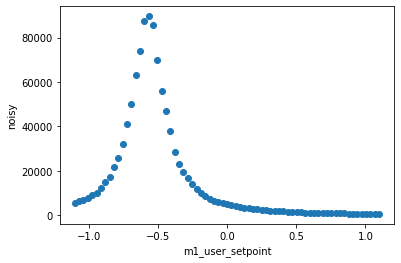

In [9]:
run = cat[-1]
data = run.flyer.read()
data.plot.scatter("m1_user_setpoint", "noisy")

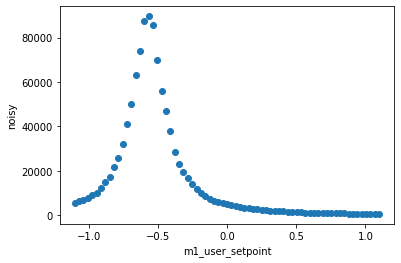

In [10]:
data = run.flyer.read()
data.plot.scatter("m1_user_setpoint", "noisy")